# Study on co-actors communities and their correlation to movies metadata

## Introduction
This is my final project on complex networks subject. The purpose of this study is to compare the Louvain and Leiden's algorithms performance on detecting communities in weighted networks, checking basic structure properties of the network, and finally analysing if actors of the same community share genres that they tend to work on, spoken languages or even simillar ages. The data used for this was extracted from [imdb's dataset](https://developer.imdb.com/non-commercial-datasets/), and for the Louvain and Leiden's algorithm I used nvidia's cugraph back-end for NetworkX.

In this repository there is also a c++ file that is used to extract and format the important data, and a python file that finds and saves the communities for the network. Instructions on how to use them can be found in the README file.

After the main network, I have applied two cuts that will be treated separately: movies from the US (or that have spoken english language and were available there), and movies from Brazil. Since the dataset doesn't directly tell the spoken language of the original version of the movie, I did a workaround by checking if the title matches the ones from either region to select where it belongs to. I believe that there will be some exceptions, but got enough right so that studying these cuts actually make sense. As I mentioned before, I also ran two separate community finding algorithms: Louvain and Leiden (this last one has random components to it, so I ran it 30 times and picked the partition that had the best modularity).

## Helping functions
Below are the imports and basic functions that I will use

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from scipy.spatial.distance import euclidean
from collections import defaultdict, Counter

DATA_DIR = "./ExtractedData/"
COMMUNITY_DIR = "./Communities/"

sns.set_theme(style="whitegrid")

In [2]:
def load_all_data(filter_prefix, comm_suffix):
    """
    Loads all necessary text files based on the prefix and suffix.
    Returns a dictionary containing the Graph and DataFrames/Dictionaries.
    """
    prefix_str = filter_prefix if filter_prefix else "_"
    
    def get_data_path(filename):
        return os.path.join(DATA_DIR, f"{prefix_str}{filename}")
    
    def get_comm_path(filename):
        return os.path.join(COMMUNITY_DIR, f"{prefix_str}{filename}")

    print(f"--- Loading Data for Filter: '{filter_prefix}' and Algo: '{comm_suffix}' ---")

    network_path = get_data_path("network.txt")
    if not os.path.exists(network_path):
        raise FileNotFoundError(f"Network file not found: {network_path}")
    G = nx.read_weighted_edgelist(network_path, delimiter=" ", nodetype=str)
    
    comm_path = get_comm_path(f"communities{comm_suffix}.txt")
    if not os.path.exists(comm_path):
        raise FileNotFoundError(f"Community file not found: {comm_path}")
    df_communities = pd.read_csv(comm_path, sep=" ", names=["nconst", "community"], dtype=str)

    df_birth = pd.read_csv(get_data_path("peopleByBirthYear.txt"), sep=" ", names=["nconst", "birthYear"], na_values="\\N")
    
    movie_genres = {}
    genre_path = get_data_path("genresByMovie.txt")
    if os.path.exists(genre_path):
        with open(genre_path, 'r') as f:
            for line in f:
                parts = line.strip().split(' ', 1)
                if len(parts) == 2:
                    movie_genres[parts[0]] = parts[1].split(',')
                else:
                    movie_genres[parts[0]] = []

    movie_regions = {}
    region_path = get_data_path("regionByMovie.txt")
    if os.path.exists(region_path):
         with open(region_path, 'r') as f:
            for line in f:
                parts = line.strip().split(' ', 1)
                val = parts[1] if len(parts) > 1 else "NADA"
                movie_regions[parts[0]] = val

    person_movies = {}
    pm_path = get_data_path("moviesbyperson.txt")
    if os.path.exists(pm_path):
        with open(pm_path, 'r') as f:
            for line in f:
                parts = line.strip().split(' ')
                if len(parts) > 2:
                    nconst = parts[0]
                    movies = parts[2:]
                    person_movies[nconst] = movies

    print("Data Loaded Successfully.")
    
    # Returns everything in a dictionary
    return {
        "G": G,
        "df_communities": df_communities,
        "df_birth": df_birth,
        "movie_genres": movie_genres,
        "movie_regions": movie_regions,
        "person_movies": person_movies
    }

In [3]:
def analyze_topology(G, title_suffix=""):
    """Analyzes basic graph structure and plots Degree CCDF."""
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    density = nx.density(G)

    print(f"Nodes: {num_nodes}")
    print(f"Edges: {num_edges}")
    print(f"Density: {density:.6f}")
    degrees = [d for n, d in G.degree()]
    sorted_degrees = np.sort(degrees)
    
    yvals = np.arange(len(sorted_degrees), 0, -1) / float(len(sorted_degrees))
    
    plt.figure(figsize=(10, 6))
    plt.loglog(sorted_degrees, yvals, marker='.', linestyle='none', color='navy', alpha=0.5)
    
    plt.title(f"Degree Distribution (CCDF) - {title_suffix}")
    plt.xlabel("Degree (k)")
    plt.ylabel("P(Degree >= k)")
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.show()

def analyze_community_sizes(df_communities, G, title_suffix=""):
    """Analyzes size distribution of communities."""
    node_degrees = dict(G.degree())
    df_communities['degree'] = df_communities['nconst'].map(node_degrees)

    comm_sizes = df_communities['community'].value_counts()
    print(f"Total Communities: {len(comm_sizes)}")
    print("Top 10 Largest Communities:")
    print(comm_sizes.head(10))

    plt.figure(figsize=(12, 6))
    sns.barplot(x=comm_sizes.head(20).index, y=comm_sizes.head(20).values)
    plt.title(f"Size of Top 20 Communities - {title_suffix}")
    plt.xlabel("Community ID")
    plt.ylabel("Members")
    plt.xticks(rotation=45)
    plt.show()
    return comm_sizes

def plot_community_size_ccdf(comm_sizes, title_suffix=""):
    """Plots the CCDF of community sizes (Linear Scale)."""
    sizes = comm_sizes.values
    
    sorted_sizes = np.sort(sizes)
    yvals = np.arange(len(sorted_sizes), 0, -1) / float(len(sorted_sizes))
    
    plt.figure(figsize=(10, 6))
    plt.loglog(sorted_sizes, yvals, marker='.', linestyle='none', color='green', alpha=0.6)
    
    plt.title(f"Community Size Distribution (CCDF) - {title_suffix}")
    plt.xlabel("Community Size (Number of People)")
    plt.ylabel("P(Size >= x)")
    plt.grid(True, alpha=0.3)
    plt.show()

def analyze_genres(df_communities, person_movies, movie_genres, comm_sizes, n_top=5):
    """Prints dominant genres for top communities."""
    
    def get_dominant_genres(community_id):
        people = df_communities[df_communities['community'] == community_id]['nconst']
        all_genres = []
        for person in people:
            movies = person_movies.get(person, [])
            for movie in movies:
                genres = movie_genres.get(movie, [])
                valid_genres = [g for g in genres if g != "\\N" and g != ""]
                all_genres.extend(valid_genres)
        return Counter(all_genres).most_common(n_top)

    top_5_comms = comm_sizes.head(5).index
    print("\n--- Genre Profiles for Top 5 Communities ---")
    for comm_id in top_5_comms:
        top_genres = get_dominant_genres(comm_id)
        print(f"\nCommunity {comm_id} (Size: {comm_sizes[comm_id]}):")
        for genre, count in top_genres:
            print(f"   - {genre}: {count}")

def compute_homophily(data, sample_size=50000):
    """
    Builds feature vectors (Genre, Region, Age) and computes Intra/Inter distances.
    """
    print("\n--- Building Feature Vectors & Computing Distances ---")
    
    df_comm = data['df_communities']
    movie_genres = data['movie_genres']
    movie_regions = data['movie_regions']
    person_movies = data['person_movies']
    
    # 2025 is the reference year for age calculation
    person_birth_map = {}
    for _, row in data['df_birth'].dropna().iterrows():
        try:
            person_birth_map[str(row['nconst'])] = int(row['birthYear'])
        except:
            pass

    all_genres = set()
    for g_list in movie_genres.values():
        for g in g_list:
            if g != "\\N" and g != "": all_genres.add(g)
            
    all_regions = set()
    for r in movie_regions.values():
        if r != "NADA" and r != "\\N": all_regions.add(r)
            
    sorted_genres = sorted(list(all_genres))
    sorted_regions = sorted(list(all_regions))
    
    genre_to_idx = {g: i for i, g in enumerate(sorted_genres)}
    region_to_idx = {r: i for i, r in enumerate(sorted_regions)}
    
    num_genres = len(sorted_genres)
    num_regions = len(sorted_regions)
    
    actor_vectors = {}
    
    for nconst in df_comm['nconst']:
        if nconst not in person_movies: continue
        
        movies = person_movies[nconst]
        
        # Genre Vector
        g_vec = np.zeros(num_genres)
        total_g = 0
        for m in movies:
            if m in movie_genres:
                for g in movie_genres[m]:
                    if g in genre_to_idx:
                        g_vec[genre_to_idx[g]] += 1
                        total_g += 1
        if total_g > 0: g_vec /= total_g
            
        # Region Vector
        r_vec = np.zeros(num_regions)
        total_r = 0
        for m in movies:
            if m in movie_regions:
                r = movie_regions[m]
                if r in region_to_idx:
                    r_vec[region_to_idx[r]] += 1
                    total_r += 1
        if total_r > 0: r_vec /= total_r
            
        # Age Vector
        if nconst in person_birth_map:
            age = 2025 - person_birth_map[nconst]
            age_norm = age / 50.0
        else:
            age_norm = 1.0
            
        actor_vectors[nconst] = np.concatenate([g_vec, r_vec, [age_norm]])

    print(f"Vectors built for {len(actor_vectors)} actors.")
    
    # Sampling Distances
    comm_groups = defaultdict(list)
    for n, c in zip(df_comm['nconst'], df_comm['community']):
        comm_groups[c].append(n)
        
    valid_comms = [c for c in comm_groups if len(comm_groups[c]) >= 2]
    valid_actors_list = list(actor_vectors.keys())
    
    node_to_comm = dict(zip(df_comm['nconst'], df_comm['community']))

    intra_dists = []
    inter_dists = []
    
    print("Sampling INTRA distances...")
    for _ in range(sample_size):
        c = random.choice(valid_comms)
        members = comm_groups[c]
        valid_m = [m for m in members if m in actor_vectors]
        if len(valid_m) < 2: continue
        
        a, b = random.sample(valid_m, 2)
        intra_dists.append(euclidean(actor_vectors[a], actor_vectors[b]))
        
    print("Sampling INTER distances...")
    for _ in range(sample_size):
        a = random.choice(valid_actors_list)
        b = random.choice(valid_actors_list)
        
        if node_to_comm.get(a) != node_to_comm.get(b):
            inter_dists.append(euclidean(actor_vectors[a], actor_vectors[b]))
            
    return intra_dists, inter_dists

def plot_homophily(intra, inter, title_suffix=""):
    def get_ccdf(data):
        sorted_data = np.sort(data)
        yvals = np.arange(len(sorted_data)) / float(len(sorted_data) - 1)
        return sorted_data, 1 - yvals

    plt.figure(figsize=(10, 6))
    x_intra, y_intra = get_ccdf(intra)
    x_inter, y_inter = get_ccdf(inter)
    
    plt.plot(x_intra, y_intra, label="Intra-Community", color="blue")
    plt.plot(x_inter, y_inter, label="Inter-Community", color="red")
    
    plt.title(f"CCDF of Euclidean Distance - {title_suffix}")
    plt.xlabel("Distance")
    plt.ylabel("P(d > x)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Mean Intra Distance: {np.mean(intra):.4f}")
    print(f"Mean Inter Distance: {np.mean(inter):.4f}")

In [4]:
def run_topology(filter_prefix, comm_suffix):
    """
    Function for topology analysis.
    filter_prefix: e.g., "US", "BR", or "" (empty string for global)
    comm_suffix: e.g., "_louvain", "_leiden"
    """

    # Load
    data = load_all_data(filter_prefix, comm_suffix)
    run_name = f"{filter_prefix if filter_prefix else 'Global'}{comm_suffix}"
    
    # Topology
    analyze_topology(data['G'], title_suffix=run_name)

    # Biggest Communities
    comm_sizes = analyze_community_sizes(data['df_communities'], data['G'], title_suffix=run_name)

    # Community Sizes
    plot_community_size_ccdf(comm_sizes, title_suffix=run_name)
    
    # Genre Analysis
    analyze_genres(
        data['df_communities'], 
        data['person_movies'], 
        data['movie_genres'], 
        comm_sizes
    )
    

def run_analysis(filter_prefix, comm_suffix):
    """
    Main vector analysis function.
    filter_prefix: e.g., "US", "BR", or "" (empty string for global)
    comm_suffix: e.g., "_louvain", "_leiden"
    """
    
    # Load
    data = load_all_data(filter_prefix, comm_suffix)
    run_name = f"{filter_prefix if filter_prefix else 'Global'}{comm_suffix}"

    # Homophily / Vector Analysis
    intra, inter = compute_homophily(data)
    plot_homophily(intra, inter, title_suffix=run_name)

## Structure of the network
This will consider number of nodes in each community, the biggest communities, the distribution of the size of communities, and finally distribution of genres among the top communities.

### General network

--- Loading Data for Filter: '' and Algo: '_louvain' ---
Data Loaded Successfully.
Nodes: 1666051
Edges: 20294515
Density: 0.000015


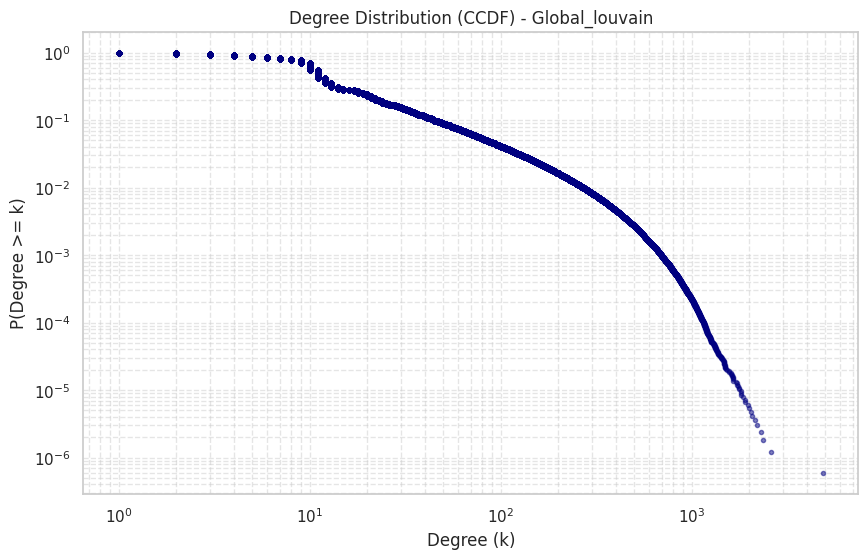

Total Communities: 30951
Top 10 Largest Communities:
community
10070    290474
1040      81626
365       79241
325       76948
317       70861
10098     61734
18581     57640
455       53233
92        50472
1699      49481
Name: count, dtype: int64


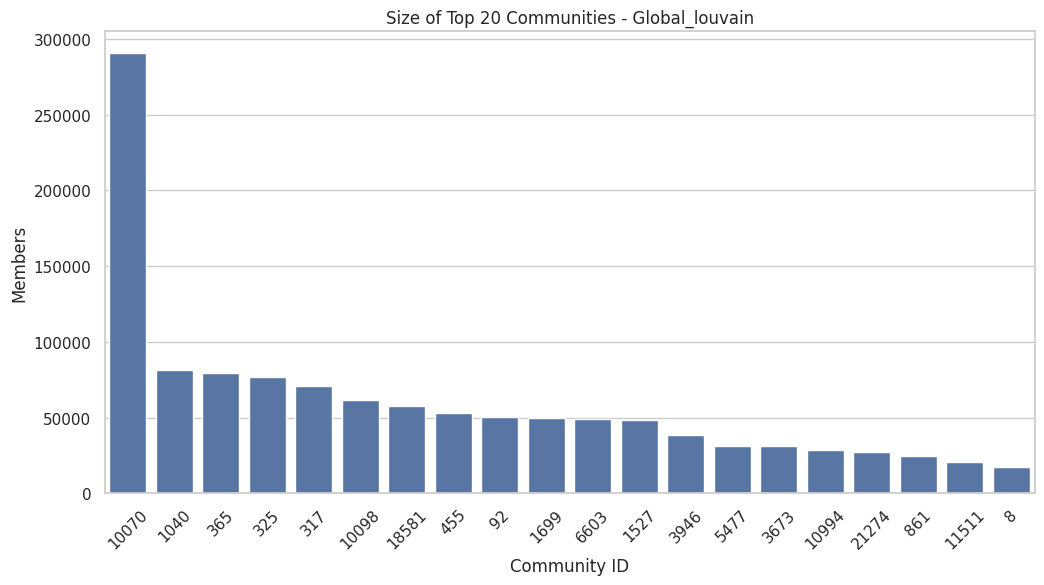

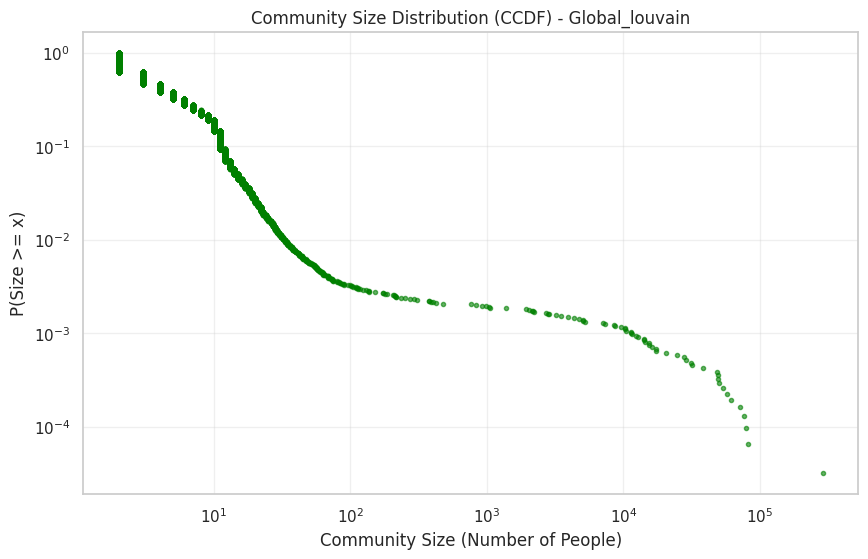


--- Genre Profiles for Top 5 Communities ---

Community 10070 (Size: 290474):
   - Drama: 396437
   - Comedy: 257628
   - Thriller: 154434
   - Horror: 135608
   - Action: 119131

Community 1040 (Size: 81626):
   - Drama: 60735
   - Horror: 46400
   - Comedy: 35170
   - Thriller: 25011
   - Action: 17423

Community 365 (Size: 79241):
   - Drama: 110913
   - Comedy: 56088
   - Horror: 32762
   - Thriller: 30946
   - Crime: 29902

Community 325 (Size: 76948):
   - Drama: 133054
   - Comedy: 78418
   - Documentary: 30890
   - Romance: 23899
   - Crime: 21691

Community 317 (Size: 70861):
   - Drama: 151168
   - Action: 49283
   - Comedy: 44867
   - Romance: 42577
   - Thriller: 24997


In [5]:
run_topology("", "_louvain")

We can notice how the degree distribution doesn't seem to follow a power of law, as there is a curve that follows a rappid descent in the number of actors with higher degrees. I believe that there is a limit to how many people an actor can work with in a lifetime, and this distribution looks closes to a log-normal.

It is worth noting how the top communities distribution of genres does not seem to have a specific genre that stands out. More on this during the vector analysis.

### US network

--- Loading Data for Filter: 'US' and Algo: '_louvain' ---
Data Loaded Successfully.
Nodes: 777021
Edges: 8135813
Density: 0.000027


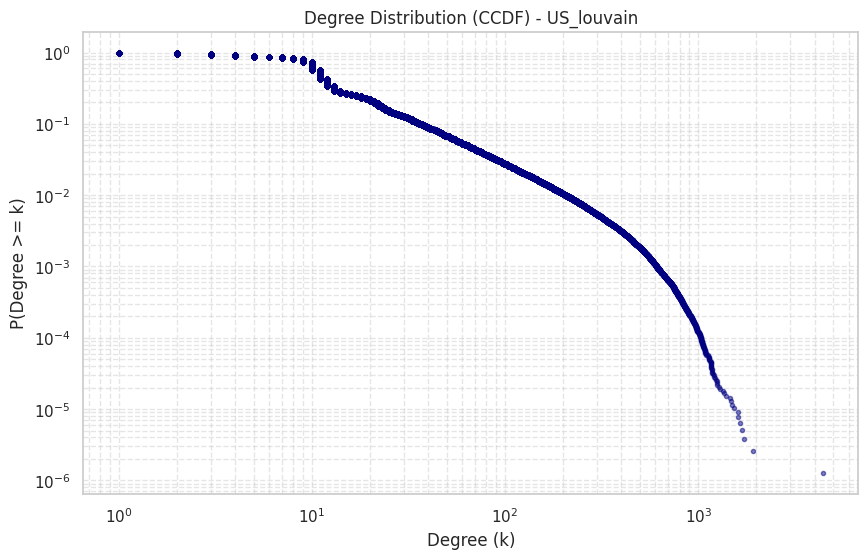

Total Communities: 16328
Top 10 Largest Communities:
community
0     121194
2      59363
3      41475
1      40388
4      38660
16     32667
7      23755
6      20860
18     17956
5      17755
Name: count, dtype: int64


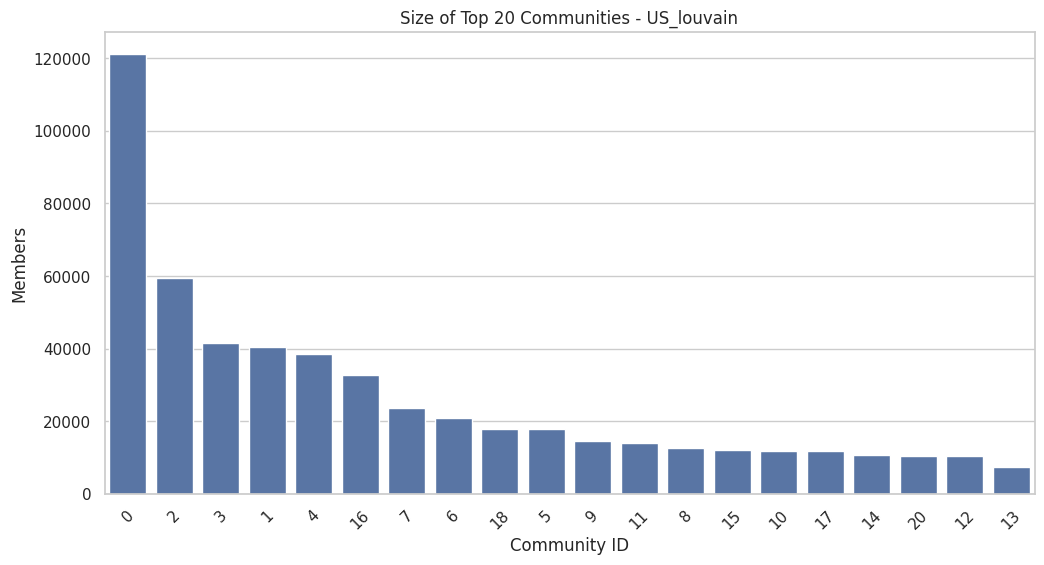

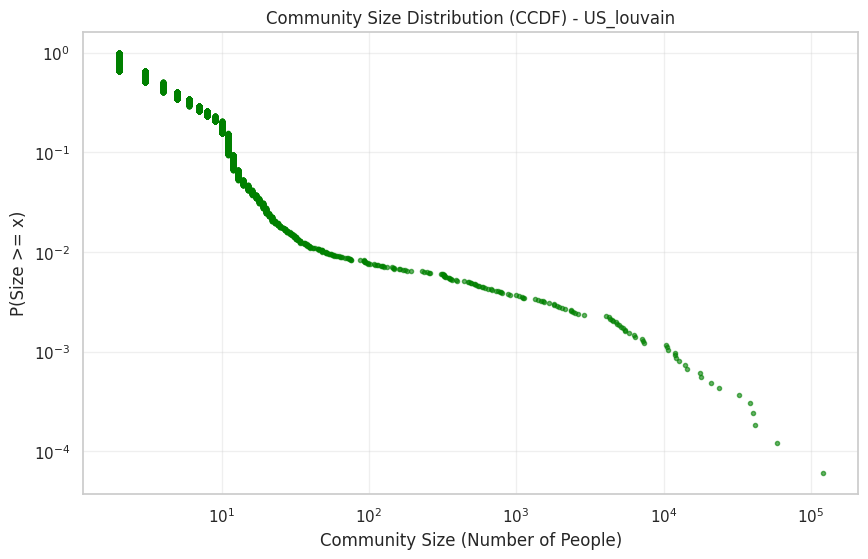


--- Genre Profiles for Top 5 Communities ---

Community 0 (Size: 121194):
   - Drama: 240491
   - Comedy: 155701
   - Thriller: 88733
   - Action: 72569
   - Crime: 61633

Community 2 (Size: 59363):
   - Drama: 44948
   - Horror: 42466
   - Comedy: 32400
   - Thriller: 24053
   - Action: 16002

Community 3 (Size: 41475):
   - Drama: 40789
   - Comedy: 17096
   - Thriller: 15268
   - Horror: 11213
   - Action: 8661

Community 1 (Size: 40388):
   - Drama: 204967
   - Comedy: 81021
   - Romance: 59204
   - Western: 49772
   - Crime: 43964

Community 4 (Size: 38660):
   - Drama: 33338
   - Comedy: 18783
   - Horror: 12309
   - Thriller: 10688
   - Action: 6831


In [6]:
run_topology("US", "_louvain")

We can see how the overall behaviour of the US partition is similar to the general network. 

### Brazilian network

--- Loading Data for Filter: 'BR' and Algo: '_louvain' ---
Data Loaded Successfully.
Nodes: 66498
Edges: 548315
Density: 0.000248


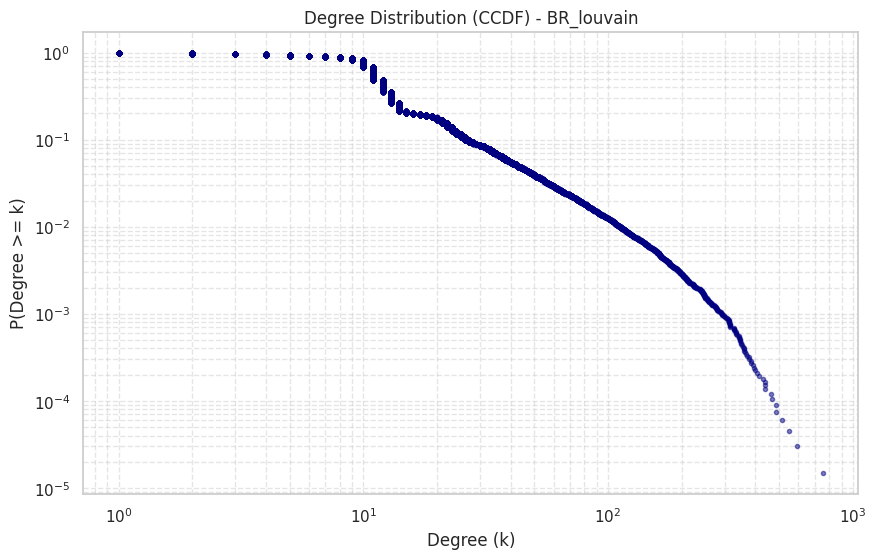

Total Communities: 1706
Top 10 Largest Communities:
community
0     8835
2     8657
1     6104
3     4900
10    1988
4     1714
5     1713
19    1483
23    1004
6      831
Name: count, dtype: int64


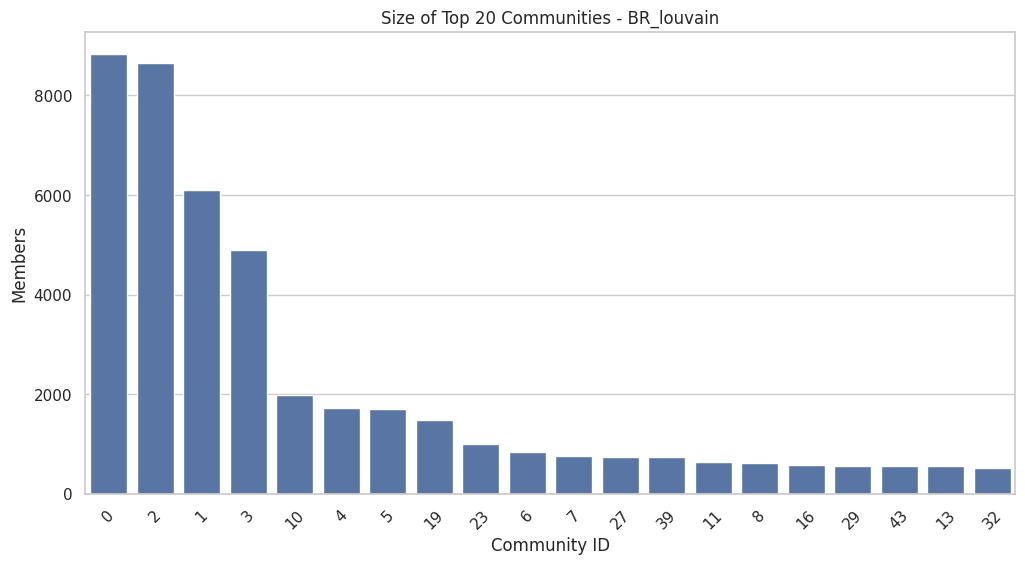

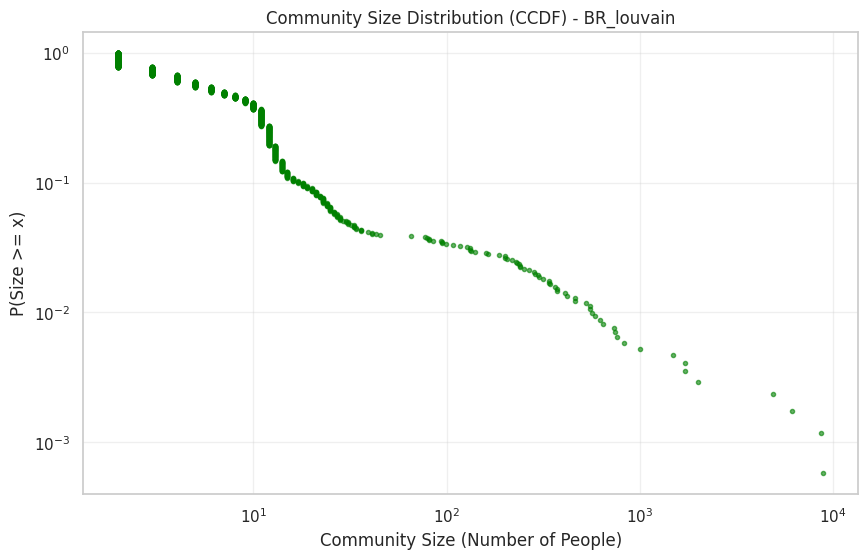


--- Genre Profiles for Top 5 Communities ---

Community 0 (Size: 8835):
   - Drama: 13475
   - Comedy: 6831
   - Documentary: 3014
   - Romance: 2398
   - Thriller: 1605

Community 2 (Size: 8657):
   - Drama: 8196
   - Comedy: 3994
   - Action: 3441
   - Adventure: 2639
   - Crime: 2199

Community 1 (Size: 6104):
   - Drama: 9294
   - Comedy: 8234
   - Crime: 1813
   - Musical: 1695
   - Adventure: 1246

Community 3 (Size: 4900):
   - Drama: 4795
   - Comedy: 1877
   - Romance: 1748
   - Adventure: 1305
   - Action: 815

Community 10 (Size: 1988):
   - Drama: 2222
   - Adult: 1828
   - Comedy: 1170
   - Crime: 787
   - Horror: 363


In [7]:
run_topology("BR", "_louvain")

The Brazilian cut, although way smaller than the others, also seems to have the same behaviour than the other ones.

## Vector and homofily analysis
To try and see if the hypothesys is right (i.e., if actors inside communities follow trends linked to movie genres, regions and their ages), I decided to approach this by making a metric that would quantify how close or distant to actors are in respect to these properties. To do that, I decided to make vectors for each actor, and their distance would be relative to the euclidian distance of these vectors. I made one that has valu that are proportional to the number of appearences for each genre, by counting for each movie that the actor worked in, and the sum of all values are equal to 1. Another would be equal to their age divided by 50 (arbitrary number). The last one is in respect to their region, made in a similar way to the genre vector.

Since there are way too many nodes to check the distance for each pair of actors, I decided to take a sample of each community (5000 nodes), and use them for comparison

This time, we have to test the six different partitions and see how they compare to each other based on this metric.

--- Loading Data for Filter: '' and Algo: '_louvain' ---
Data Loaded Successfully.

--- Building Feature Vectors & Computing Distances ---
Vectors built for 1666051 actors.
Sampling INTRA distances...
Sampling INTER distances...


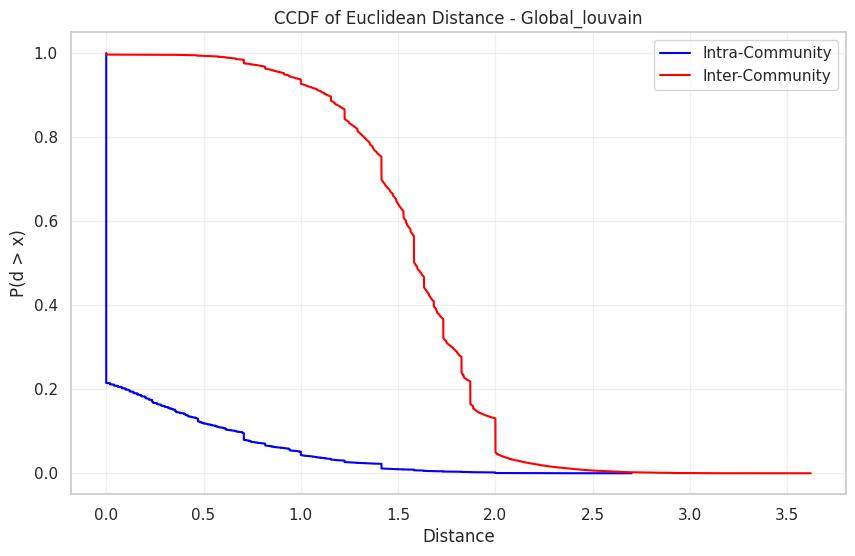

Mean Intra Distance: 0.1424
Mean Inter Distance: 1.5785


In [8]:
run_analysis("", "_louvain")

--- Loading Data for Filter: '' and Algo: '_leiden' ---
Data Loaded Successfully.

--- Building Feature Vectors & Computing Distances ---
Vectors built for 1666051 actors.
Sampling INTRA distances...
Sampling INTER distances...


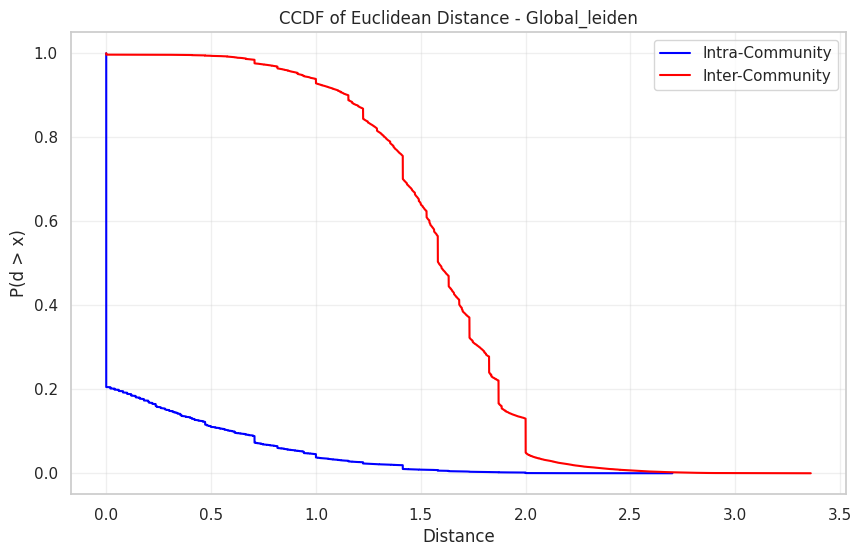

Mean Intra Distance: 0.1321
Mean Inter Distance: 1.5799


In [9]:
run_analysis("", "_leiden")

--- Loading Data for Filter: 'US' and Algo: '_louvain' ---
Data Loaded Successfully.

--- Building Feature Vectors & Computing Distances ---
Vectors built for 777021 actors.
Sampling INTRA distances...
Sampling INTER distances...


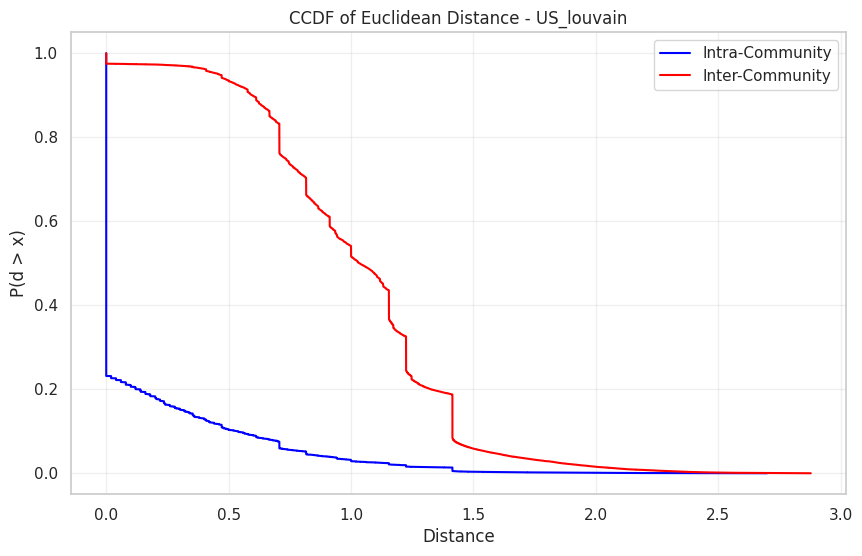

Mean Intra Distance: 0.1253
Mean Inter Distance: 1.0219


In [10]:
run_analysis("US", "_louvain")

--- Loading Data for Filter: 'US' and Algo: '_leiden' ---
Data Loaded Successfully.

--- Building Feature Vectors & Computing Distances ---
Vectors built for 777021 actors.
Sampling INTRA distances...
Sampling INTER distances...


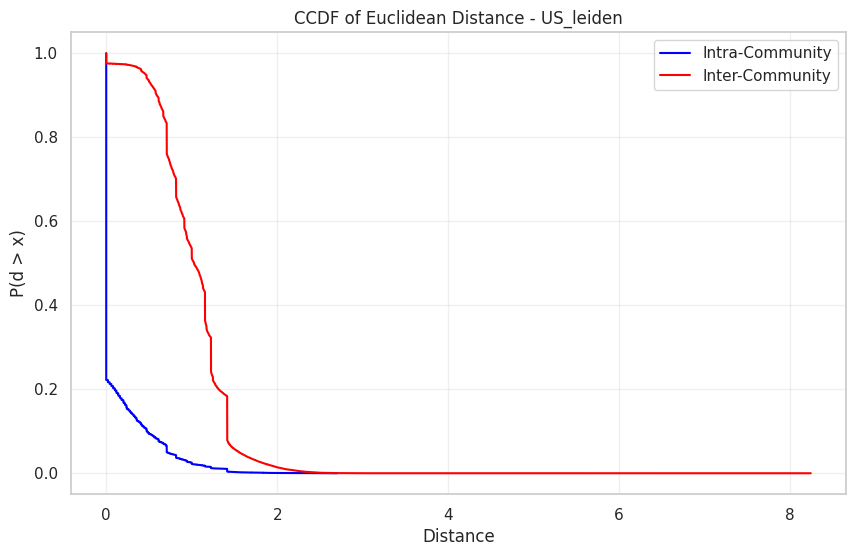

Mean Intra Distance: 0.1140
Mean Inter Distance: 1.0186


In [11]:
run_analysis("US", "_leiden")

--- Loading Data for Filter: 'BR' and Algo: '_louvain' ---
Data Loaded Successfully.

--- Building Feature Vectors & Computing Distances ---
Vectors built for 66498 actors.
Sampling INTRA distances...
Sampling INTER distances...


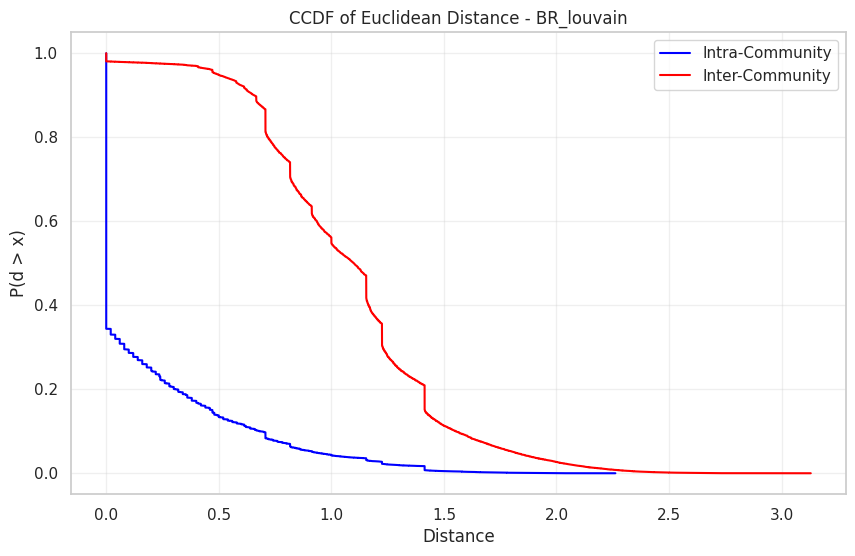

Mean Intra Distance: 0.1703
Mean Inter Distance: 1.0757


In [12]:
run_analysis("BR", "_louvain")

--- Loading Data for Filter: 'BR' and Algo: '_leiden' ---
Data Loaded Successfully.

--- Building Feature Vectors & Computing Distances ---
Vectors built for 66498 actors.
Sampling INTRA distances...
Sampling INTER distances...


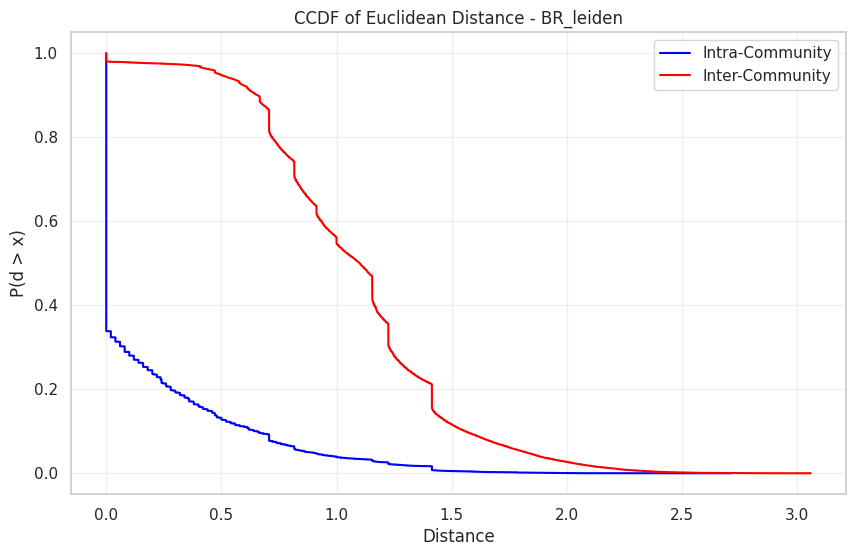

Mean Intra Distance: 0.1634
Mean Inter Distance: 1.0771


In [13]:
run_analysis("BR", "_leiden")

All community partitions ended up having really close distributions of distances over nodes of same and different communities. In all cases, there is a big ammount of pairs of nodes intra-communities that have a distance of 0. This is probably due to many actors of the same region making few movies of the same genre. In this particular dataset, the age of many actors is missing, which may also help to explain many having the distance being so close. Then, it is undeniable that there is a correlation to a certain extent between movie genres, and regions mainly to the communities that are formed, since the Mean Intra Distance consistently is one order of magnitude lower than Mean Inter Distance. With this, we can confirm our initial hypothesis.

In regards to the difference in perfomance between both algorithms, it seems that Leiden is better overall, but only by a small ammount.

## Conclusions

All different cuts have behaved in simillar ways throughout all tested metrics, which concludes that structure wise, Brazilian, US and global actor networks are really similar. We were able to empirically show that one's preference to genre and their region and age contribute to how they build relationships in movies that they work in, even if it doesn't seem to be obvious at a first glance. This subtleness seems to be present in most real networks, with some factors majorly interfering in their grownth.